## 1. Importação de Bibliotecas

In [1]:
import os
import sys
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2026-01-05 14:57:45.107869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 14:57:45.167899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 14:58:00.056314: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/mnt/c/Users/djefe/Documents/repos/fiap-mlet-fase4/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
NumPy version: 1.26.3
Pandas version: 2.1.4


## 2. Coleta de Dados

Utilizamos a biblioteca `yfinance` para obter dados históricos da **PETR4.SA** (Petrobras) na B3.

In [2]:
# Configuração da coleta
SYMBOL = 'BTC-USD'  # Petrobras
START_DATE = '2018-01-01'  
END_DATE = datetime.now().strftime('%Y-%m-%d')

print(f"Coletando dados de {SYMBOL}")
print(f"Período: {START_DATE} até {END_DATE}")
print("-" * 50)

# Download dos dados
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=True) 

# Remove MultiIndex se existir
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"\n✓ Dados coletados: {len(df)} registros")
print(f"  Período real: {df.index.min().date()} até {df.index.max().date()}")

Coletando dados de BTC-USD
Período: 2018-01-01 até 2026-01-05
--------------------------------------------------


[*********************100%***********************]  1 of 1 completed


✓ Dados coletados: 2926 registros
  Período real: 2018-01-01 até 2026-01-04


In [3]:
# Visualização inicial dos dados
print("Primeiras linhas:")
display(df.head())

print("\nÚltimas linhas:")
display(df.tail())

print("\nInformações do DataFrame:")
df.info()

Primeiras linhas:


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072



Últimas linhas:


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-12-31,87508.828125,89080.289062,87130.562500,88429.585938,33830210616
2026-01-01,88731.984375,88803.226562,87399.406250,87508.046875,18849043990
2026-01-02,89944.695312,90884.460938,88298.617188,88733.062500,46398906171
2026-01-03,90603.187500,90679.570312,89328.070312,89945.054688,20774828592
2026-01-04,91413.492188,91712.585938,90595.101562,90603.000000,26770491368



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2926 entries, 2018-01-01 to 2026-01-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2926 non-null   float64
 1   High    2926 non-null   float64
 2   Low     2926 non-null   float64
 3   Open    2926 non-null   float64
 4   Volume  2926 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 137.2 KB


In [4]:
# Estatísticas descritivas
print("Estatísticas Descritivas:")
display(df.describe())

Estatísticas Descritivas:


Price,Close,High,Low,Open,Volume
count,2926.000000,2926.000000,2926.000000,2926.000000,2.926000e+03
mean,37346.195617,38060.961292,36538.140674,37321.127266,3.021250e+10
std,32251.575699,32765.478270,31683.174363,32239.537039,2.199005e+10
min,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,9477.650635,9655.335938,9270.674805,9478.349121,1.530479e+10
50%,27394.911133,27829.167969,26881.308594,27376.083008,2.609323e+10
75%,57513.763672,58758.709961,55995.268555,57524.596680,3.975322e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


## 3. Feature Engineering - Indicadores Técnicos

Para melhorar o modelo, vamos adicionar indicadores técnicos que capturam diferentes aspectos do comportamento do mercado:

- **RSI** (Relative Strength Index): Momentum
- **MACD**: Tendência
- **Bollinger Bands**: Volatilidade
- **ATR** (Average True Range): Volatilidade
- **Retornos Logarítmicos**: Variação normalizada

In [5]:
def add_technical_indicators(df):
    """
    Adiciona indicadores técnicos ao DataFrame.
    """
    df = df.copy()
    
    # RSI (Relative Strength Index) - 14 períodos
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # ATR (Average True Range) - Volatilidade
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Retornos logarítmicos
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Volatilidade histórica (20 dias)
    df['Volatility'] = df['Log_Return'].rolling(window=20).std() * np.sqrt(252)
    
    # Médias móveis como features
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    
    # Momentum
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    
    # Volume normalizado
    df['Volume_Norm'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    
    # Price Rate of Change (ROC)
    df['ROC'] = (df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10) * 100
    
    return df

# Aplica feature engineering
df = add_technical_indicators(df)

# Remove linhas com NaN (primeiras linhas devido aos indicadores)
df_clean = df.dropna()

print(f"Registros após feature engineering: {len(df_clean)}")
print(f"Features criadas: {len(df_clean.columns)}")
print(f"\nColunas disponíveis:")
print(df_clean.columns.tolist())

Registros após feature engineering: 2897
Features criadas: 23

Colunas disponíveis:
['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'ATR', 'Log_Return', 'Volatility', 'SMA_10', 'SMA_30', 'EMA_10', 'Momentum_10', 'Volume_Norm', 'ROC']


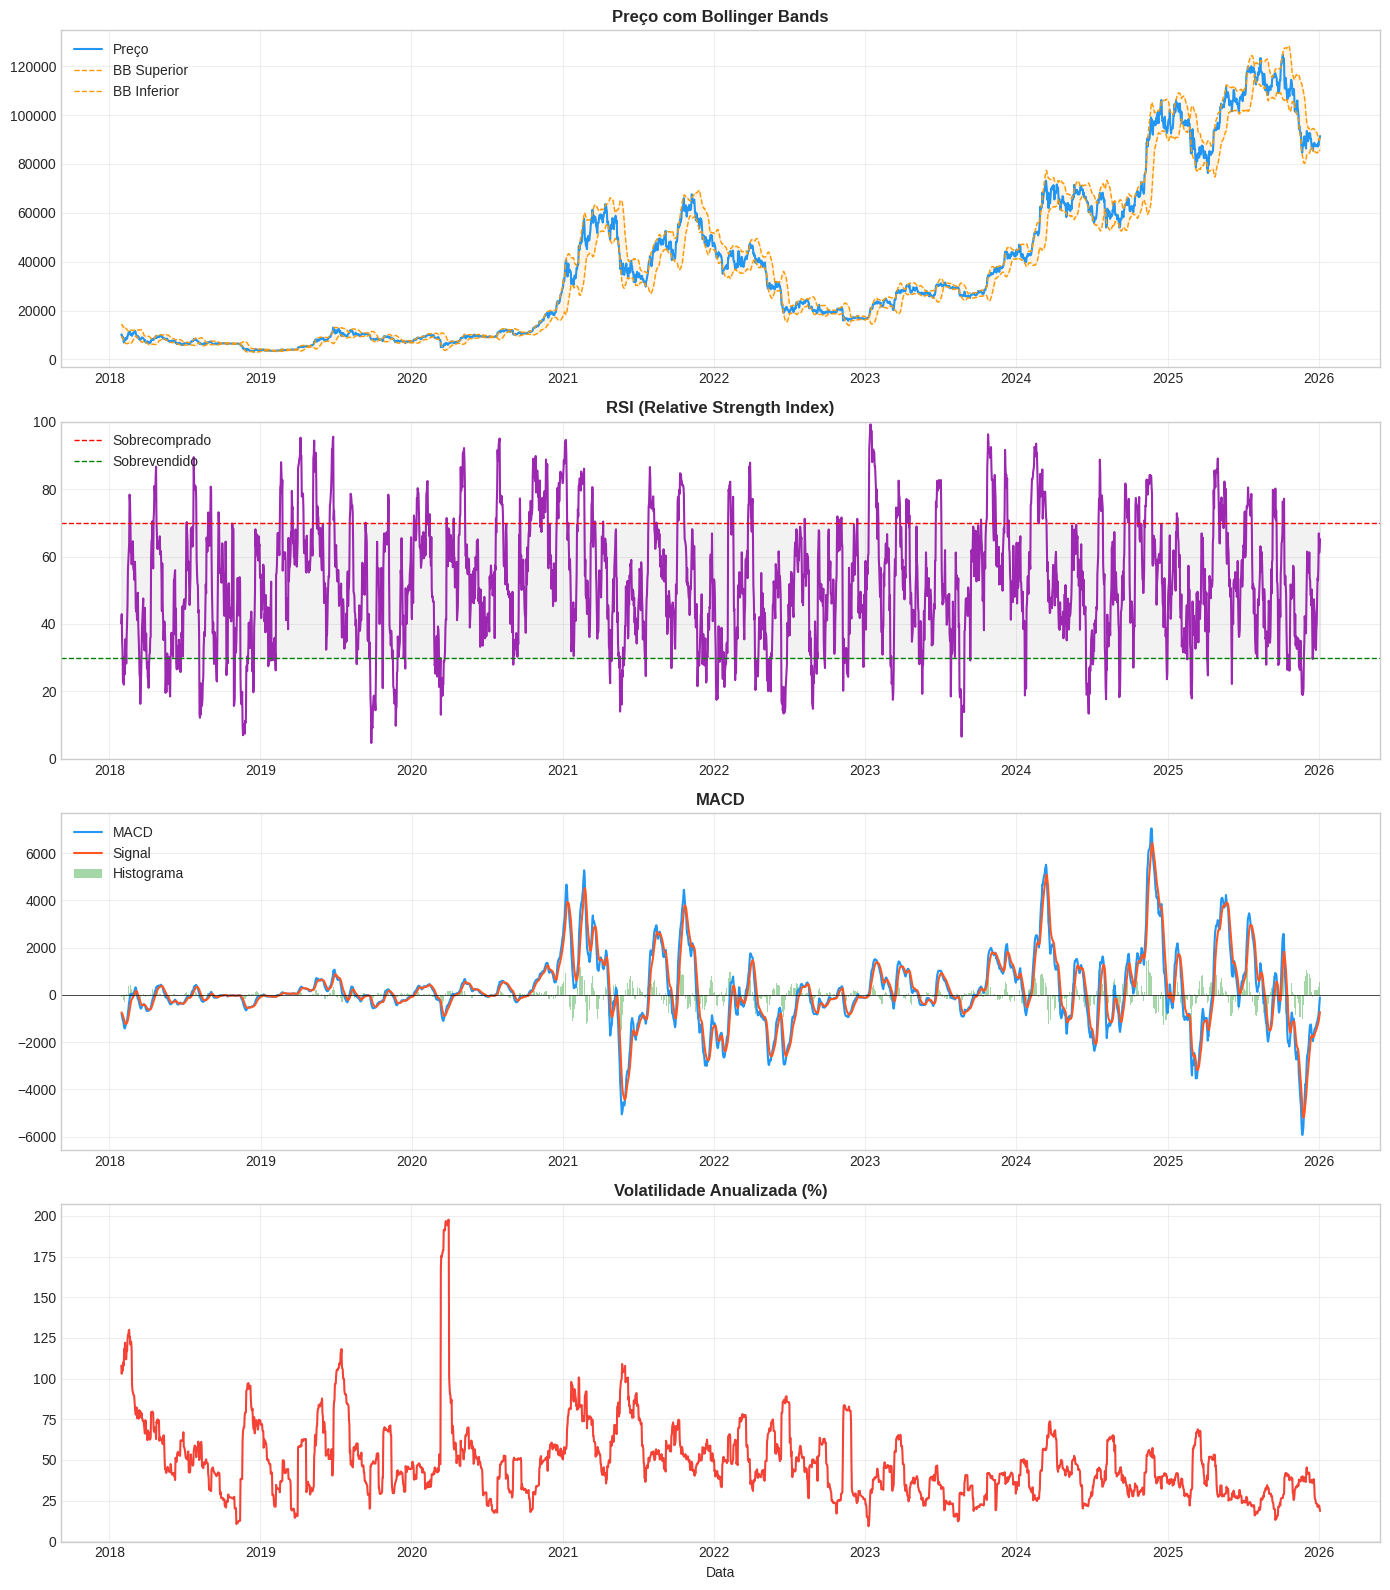

In [6]:
# Visualização dos indicadores técnicos
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Preço com Bollinger Bands
axes[0].plot(df_clean.index, df_clean['Close'], label='Preço', color='#2196F3', linewidth=1.5)
axes[0].plot(df_clean.index, df_clean['BB_Upper'], label='BB Superior', color='#FF9800', linewidth=1, linestyle='--')
axes[0].plot(df_clean.index, df_clean['BB_Lower'], label='BB Inferior', color='#FF9800', linewidth=1, linestyle='--')
axes[0].fill_between(df_clean.index, df_clean['BB_Lower'], df_clean['BB_Upper'], alpha=0.1, color='#FF9800')
axes[0].set_title('Preço com Bollinger Bands', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(df_clean.index, df_clean['RSI'], color='#9C27B0', linewidth=1.5)
axes[1].axhline(y=70, color='red', linestyle='--', linewidth=1, label='Sobrecomprado')
axes[1].axhline(y=30, color='green', linestyle='--', linewidth=1, label='Sobrevendido')
axes[1].fill_between(df_clean.index, 30, 70, alpha=0.1, color='gray')
axes[1].set_title('RSI (Relative Strength Index)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# MACD
axes[2].plot(df_clean.index, df_clean['MACD'], label='MACD', color='#2196F3', linewidth=1.5)
axes[2].plot(df_clean.index, df_clean['MACD_Signal'], label='Signal', color='#FF5722', linewidth=1.5)
axes[2].bar(df_clean.index, df_clean['MACD_Hist'], label='Histograma', color='#4CAF50', alpha=0.5)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('MACD', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# Volatilidade
axes[3].plot(df_clean.index, df_clean['Volatility'] * 100, color='#F44336', linewidth=1.5)
axes[3].set_title('Volatilidade Anualizada (%)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Data')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/technical_indicators.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Análise Exploratória de Dados (EDA)

Vamos analisar os padrões históricos dos preços da PETR4.SA.

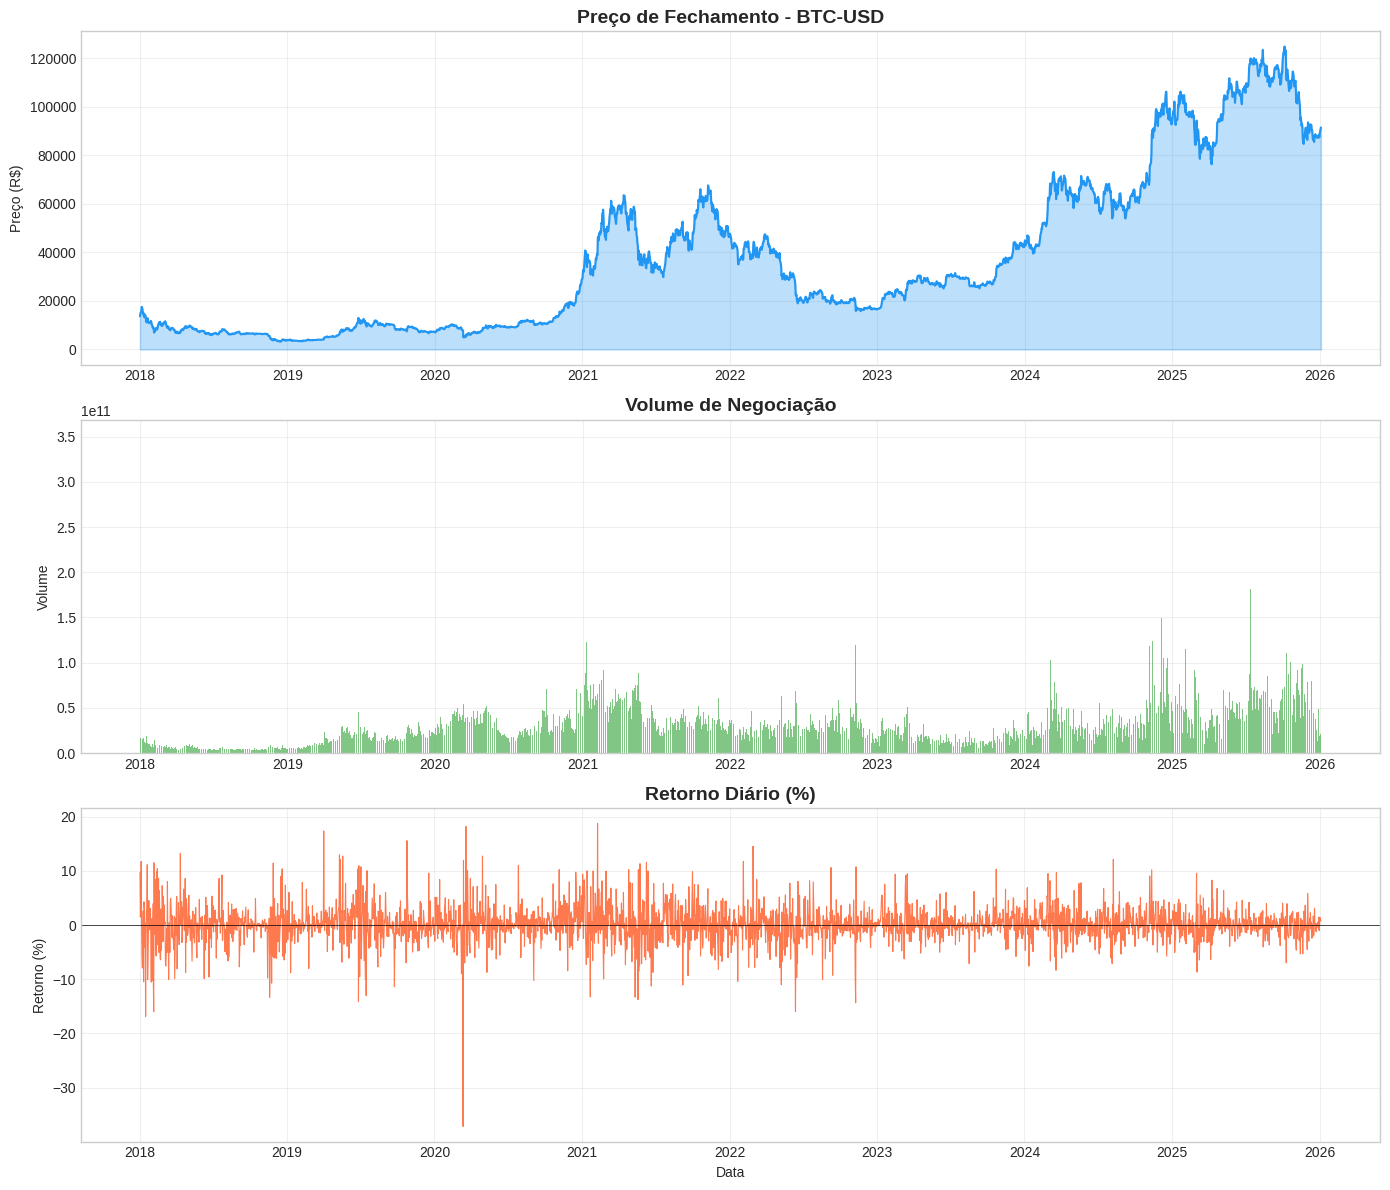

In [7]:
# Gráfico de preços históricos
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Preço de fechamento
axes[0].plot(df.index, df['Close'], color='#2196F3', linewidth=1.5)
axes[0].fill_between(df.index, df['Close'], alpha=0.3, color='#2196F3')
axes[0].set_title(f'Preço de Fechamento - {SYMBOL}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Preço (R$)')
axes[0].grid(True, alpha=0.3)

# Volume de negociação
axes[1].bar(df.index, df['Volume'], color='#4CAF50', alpha=0.7)
axes[1].set_title('Volume de Negociação', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

# Variação diária
df['Daily_Return'] = df['Close'].pct_change() * 100
axes[2].plot(df.index, df['Daily_Return'], color='#FF5722', linewidth=0.8, alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Retorno Diário (%)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Retorno (%)')
axes[2].set_xlabel('Data')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

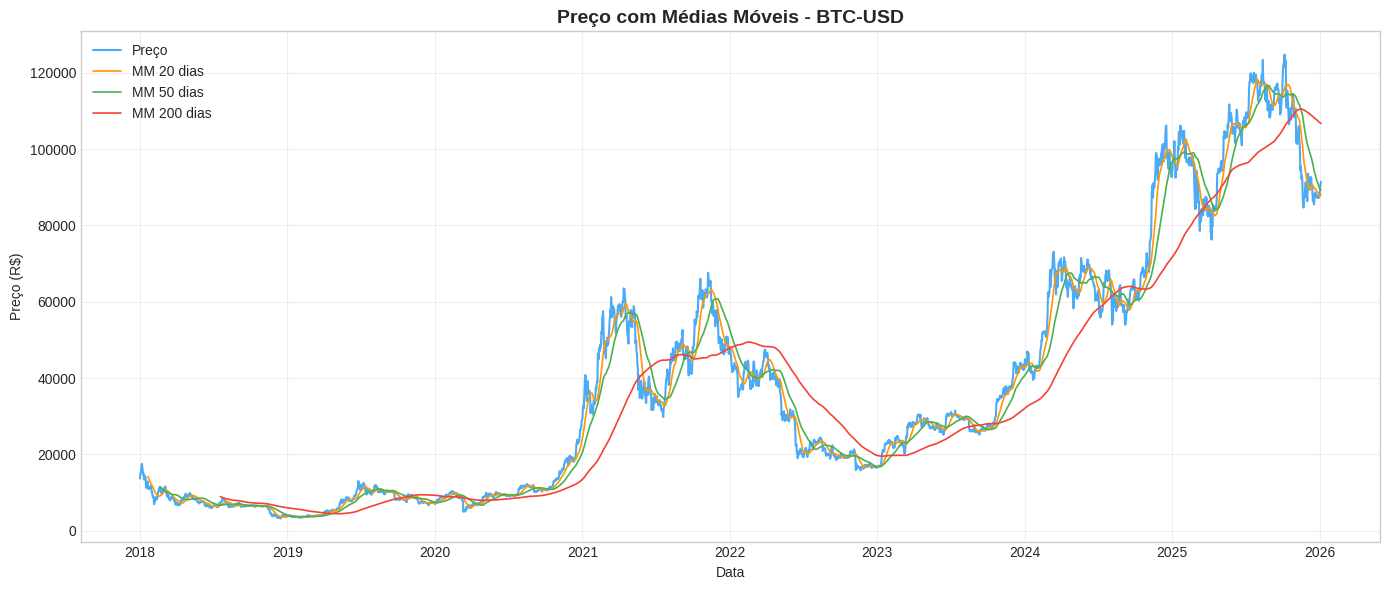

In [8]:
# Médias móveis
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['Close'], label='Preço', color='#2196F3', linewidth=1.5, alpha=0.8)
ax.plot(df.index, df['MA_20'], label='MM 20 dias', color='#FF9800', linewidth=1.2)
ax.plot(df.index, df['MA_50'], label='MM 50 dias', color='#4CAF50', linewidth=1.2)
ax.plot(df.index, df['MA_200'], label='MM 200 dias', color='#F44336', linewidth=1.2)

ax.set_title(f'Preço com Médias Móveis - {SYMBOL}', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (R$)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/moving_averages.png', dpi=150, bbox_inches='tight')
plt.show()

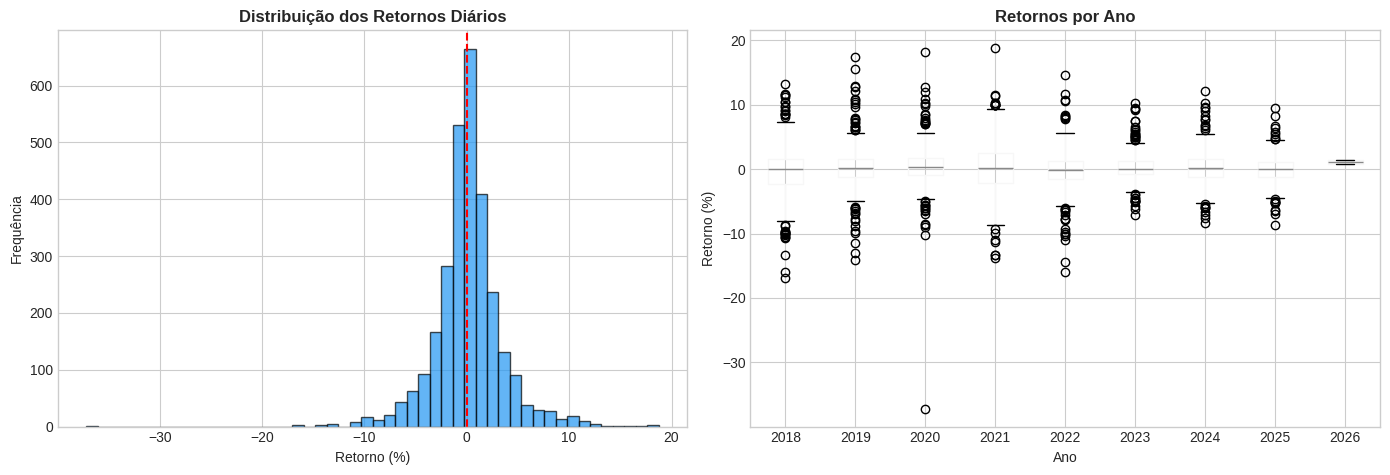

In [9]:
# Distribuição dos retornos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df['Daily_Return'].dropna(), bins=50, color='#2196F3', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('Distribuição dos Retornos Diários', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Retorno (%)')
axes[0].set_ylabel('Frequência')

# Box plot por ano
df['Year'] = df.index.year
df.boxplot(column='Daily_Return', by='Year', ax=axes[1])
axes[1].set_title('Retornos por Ano', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Retorno (%)')
plt.suptitle('')  # Remove título automático

plt.tight_layout()
plt.savefig('./data/return_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Pré-processamento dos Dados (Multivariado)

### Etapas:
1. Seleção das features mais relevantes
2. Divisão treino/teste (80/20) de forma **cronológica**
3. Normalização com **MinMaxScaler** (ajustado apenas no treino)
4. Criação de sequências temporais multivariadas

In [10]:
# Configurações do pré-processamento (OTIMIZADAS)
SEQUENCE_LENGTH = 60  # Aumentado para capturar padrões mais longos
TRAIN_RATIO = 0.80    # Mais dados para treino

# Seleção das features para o modelo
FEATURE_COLUMNS = [
    'Close',           # Target principal
    'RSI',             # Momentum
    'MACD',            # Tendência
    'MACD_Hist',       # Força da tendência
    'BB_Position',     # Posição nas bandas
    'BB_Width',        # Largura das bandas (volatilidade)
    'ATR',             # Volatilidade
    'Volatility',      # Volatilidade histórica
    'Momentum_10',     # Momentum 10 dias
    'Volume_Norm',     # Volume relativo
    'ROC',             # Rate of Change
    'Log_Return'       # Retorno logarítmico
]

# Extrai features selecionadas
features_df = df_clean[FEATURE_COLUMNS].copy()

print(f"Total de registros: {len(features_df)}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Train ratio: {TRAIN_RATIO}")
print(f"Número de features: {len(FEATURE_COLUMNS)}")
print(f"\nFeatures utilizadas:")
for i, col in enumerate(FEATURE_COLUMNS, 1):
    print(f"  {i}. {col}")

Total de registros: 2897
Sequence length: 60
Train ratio: 0.8
Número de features: 12

Features utilizadas:
  1. Close
  2. RSI
  3. MACD
  4. MACD_Hist
  5. BB_Position
  6. BB_Width
  7. ATR
  8. Volatility
  9. Momentum_10
  10. Volume_Norm
  11. ROC
  12. Log_Return


In [11]:
# Divisão cronológica treino/teste
# IMPORTANTE: Em séries temporais, NÃO embaralhamos os dados!
train_size = int(len(features_df) * TRAIN_RATIO)

train_data = features_df.iloc[:train_size].values
test_data = features_df.iloc[train_size:].values

# Guarda índices para visualização posterior
train_dates = df_clean.index[:train_size]
test_dates = df_clean.index[train_size:]

print(f"Dados de treino: {len(train_data)} registros")
print(f"Dados de teste: {len(test_data)} registros")
print(f"\nData de corte: {df_clean.index[train_size].date()}")

Dados de treino: 2317 registros
Dados de teste: 580 registros

Data de corte: 2024-06-04


In [12]:
# Normalização com MinMaxScaler para cada feature
# IMPORTANTE: Ajustar o scaler APENAS nos dados de treino para evitar data leakage

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit nos dados de treino
train_scaled = scaler_features.fit_transform(train_data)
test_scaled = scaler_features.transform(test_data)

# Scaler específico para o target (Close) - para inverse_transform depois
target_train = train_data[:, 0].reshape(-1, 1)  # Close é a primeira coluna
scaler_target.fit(target_train)

print(f"Scalers ajustados:")
print(f"  Features normalizadas: {len(FEATURE_COLUMNS)}")
print(f"  Range de Close: R$ {scaler_target.data_min_[0]:.2f} - R$ {scaler_target.data_max_[0]:.2f}")

Scalers ajustados:
  Features normalizadas: 12
  Range de Close: R$ 3236.76 - R$ 73083.50


In [13]:
def create_sequences_multivariate(data, sequence_length, target_col=0):
    """
    Cria sequências multivariadas para treinamento do LSTM.
    
    Args:
        data: Array com todas as features
        sequence_length: Número de timesteps
        target_col: Índice da coluna target (default=0 para Close)
    
    Returns:
        X: Sequências de features (samples, timesteps, features)
        y: Valores target (samples,)
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])  # Todas as features
        y.append(data[i, target_col])           # Apenas o target
    
    return np.array(X), np.array(y)

# Cria sequências de treino
X_train, y_train = create_sequences_multivariate(train_scaled, SEQUENCE_LENGTH)

# Para o teste, incluímos parte do treino para formar as primeiras sequências
full_test = np.concatenate([train_scaled[-SEQUENCE_LENGTH:], test_scaled])
X_test, y_test = create_sequences_multivariate(full_test, SEQUENCE_LENGTH)

print(f"X_train shape: {X_train.shape}  (samples, timesteps, features)")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2257, 60, 12)  (samples, timesteps, features)
y_train shape: (2257,)
X_test shape: (580, 60, 12)
y_test shape: (580,)


## 6. Construção do Modelo LSTM (Arquitetura Melhorada)

### Melhorias implementadas:
- **Bidirectional LSTM**: Captura padrões em ambas as direções
- **BatchNormalization**: Estabiliza o treinamento
- **L2 Regularization**: Previne overfitting
- **Gradient Clipping**: Evita gradientes explosivos
- **Arquitetura mais profunda**: Melhor extração de features

### Hiperparâmetros otimizados:
- LSTM units: [128, 64, 32]
- Dropout rate: 0.3
- L2 regularization: 0.001
- Otimizador: Adam com clipnorm

In [14]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_improved_lstm_model(sequence_length, n_features):
    """
    Constrói o modelo LSTM melhorado para previsão de preços.
    
    Melhorias:
    - Bidirectional LSTM para capturar padrões em ambas direções
    - BatchNormalization para estabilizar treinamento
    - L2 Regularization para prevenir overfitting
    - Dropout aumentado (0.3)
    """
    model = Sequential(name="Improved_LSTM_Stock_Predictor")
    
    # Camada de entrada
    model.add(Input(shape=(sequence_length, n_features)))
    
    # Primeira camada Bidirectional LSTM
    model.add(Bidirectional(
        LSTM(units=128, return_sequences=True, 
             kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001)),
        name='bidirectional_lstm_1'
    ))
    model.add(BatchNormalization(name='bn_1'))
    model.add(Dropout(0.3, name='dropout_1'))
    
    # Segunda camada Bidirectional LSTM
    model.add(Bidirectional(
        LSTM(units=64, return_sequences=True,
             kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001)),
        name='bidirectional_lstm_2'
    ))
    model.add(BatchNormalization(name='bn_2'))
    model.add(Dropout(0.3, name='dropout_2'))
    
    # Terceira camada LSTM (unidirecional para output)
    model.add(LSTM(units=32, return_sequences=False,
                   kernel_regularizer=l2(0.001),
                   name='lstm_3'))
    model.add(BatchNormalization(name='bn_3'))
    model.add(Dropout(0.3, name='dropout_3'))
    
    # Camadas Dense com regularização
    model.add(Dense(units=50, activation='relu', 
                    kernel_regularizer=l2(0.001),
                    name='dense_1'))
    model.add(Dropout(0.2, name='dropout_4'))
    
    model.add(Dense(units=25, activation='relu',
                    kernel_regularizer=l2(0.001),
                    name='dense_2'))
    
    # Camada de saída
    model.add(Dense(units=1, name='output'))
    
    # Compilação com gradient clipping
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='huber',  # Huber loss é mais robusto a outliers que MSE
        metrics=['mae']
    )
    
    return model

# Constrói o modelo com número correto de features
n_features = X_train.shape[2]
model = build_improved_lstm_model(SEQUENCE_LENGTH, n_features)
model.summary()

print(f"\n✓ Modelo construído com {n_features} features de entrada")

E0000 00:00:1767635936.927557   30800 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767635936.935034   30800 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "Improved_LSTM_Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_lstm_1            │ (None, 60, 256)        │       144,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 60, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 60, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 60, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,959 (1.27 MB)

 Trainable params: 333,127 (1.27 MB)

 Non-trainable params: 832 (3.25 KB)


✓ Modelo construído com 12 features de entrada


## 6. Treinamento do Modelo

### Callbacks:
- **EarlyStopping**: Para o treinamento se val_loss não melhorar por 10 épocas
- **ReduceLROnPlateau**: Reduz learning rate quando loss estagna
- **ModelCheckpoint**: Salva o melhor modelo durante o treinamento

In [15]:
# Configurações de treinamento (OTIMIZADAS)
EPOCHS = 150          # Mais épocas com early stopping
BATCH_SIZE = 32

# Callbacks melhorados
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,              # Aumentado para dar mais tempo
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001          # Melhoria mínima requerida
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='./data/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print(f"Configuração de treinamento:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Early Stopping Patience: 15")
print(f"  Learning Rate Reduction Patience: 7")
print("-" * 50)

Configuração de treinamento:
  Epochs: 150
  Batch Size: 32
  Early Stopping Patience: 15
  Learning Rate Reduction Patience: 7
--------------------------------------------------


In [16]:
# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 50)
print("✓ Treinamento concluído!")
print(f"  Épocas executadas: {len(history.history['loss'])}")
print(f"  Melhor val_loss: {min(history.history['val_loss']):.6f}")

Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.5125 - mae: 0.7411
Epoch 1: val_loss improved from None to 1.26355, saving model to ./data/best_model.keras

Epoch 1: finished saving model to ./data/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 1.2304 - mae: 0.4417 - val_loss: 1.2635 - val_mae: 0.7900 - learning_rate: 0.0010
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.9064 - mae: 0.2217
Epoch 2: val_loss improved from 1.26355 to 1.02867, saving model to ./data/best_model.keras

Epoch 2: finished saving model to ./data/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.8473 - mae: 0.2037 - val_loss: 1.0287 - val_mae: 0.7534 - learning_rate: 0.0010
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6898 - mae: 0.1633
Epoch 3: val_loss improved from 1.02867 to 0.85417, saving model to ./data/best_model.keras

Epoch 3: finished saving model to ./data/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss

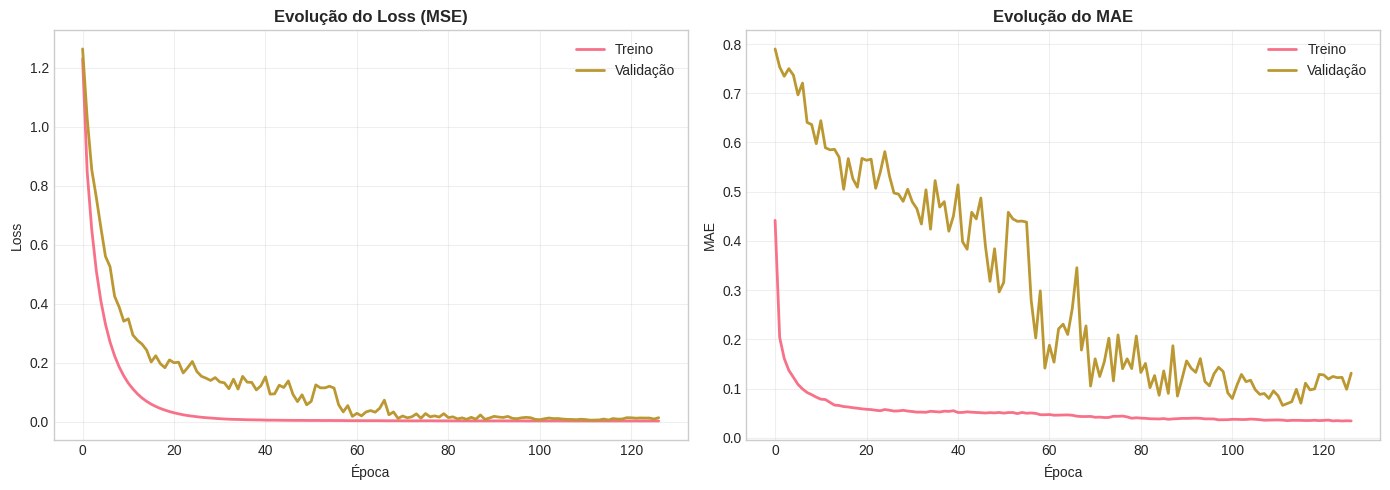

In [17]:
# Visualização do treinamento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Evolução do Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_title('Evolução do MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Avaliação do Modelo

### Métricas utilizadas:
- **MAE** (Mean Absolute Error): Erro médio em R$
- **RMSE** (Root Mean Square Error): Penaliza erros maiores
- **MAPE** (Mean Absolute Percentage Error): Erro percentual médio
- **R²** (Coeficiente de Determinação): Variância explicada pelo modelo

In [18]:
# Predições no conjunto de teste
y_pred_scaled = model.predict(X_test, verbose=0)

# Reverte normalização usando o scaler do target
y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(f"Predições realizadas: {len(y_pred)}")

Predições realizadas: 580


In [19]:
# Cálculo das métricas
def calculate_mape(y_true, y_pred):
    """Calcula MAPE evitando divisão por zero."""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = calculate_mape(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Armazena métricas
metrics = {
    'mae': float(mae),
    'rmse': float(rmse),
    'mape': float(mape),
    'r2': float(r2)
}

print("=" * 60)
print("           MÉTRICAS DE AVALIAÇÃO DO MODELO")
print("=" * 60)
print(f"\n  MAE  (Erro Absoluto Médio):      R$ {mae:.2f}")
print(f"  RMSE (Raiz Erro Quadrático):     R$ {rmse:.2f}")
print(f"  MAPE (Erro Percentual Médio):       {mape:.2f}%")
print(f"  R²   (Coef. Determinação):          {r2:.4f}")
print("\n" + "=" * 60)

# Classificação do MAPE
if mape < 10:
    mape_class = "EXCELENTE"
elif mape < 20:
    mape_class = "BOM"
elif mape < 50:
    mape_class = "RAZOÁVEL"
else:
    mape_class = "IMPRECISO"

print(f"\n  📊 Classificação do modelo (MAPE): {mape_class}")
print(f"  📈 O modelo explica {r2*100:.1f}% da variância dos preços")

           MÉTRICAS DE AVALIAÇÃO DO MODELO

  MAE  (Erro Absoluto Médio):      R$ 4595.28
  RMSE (Raiz Erro Quadrático):     R$ 6142.88
  MAPE (Erro Percentual Médio):       4.69%
  R²   (Coef. Determinação):          0.9002


  📊 Classificação do modelo (MAPE): EXCELENTE
  📈 O modelo explica 90.0% da variância dos preços


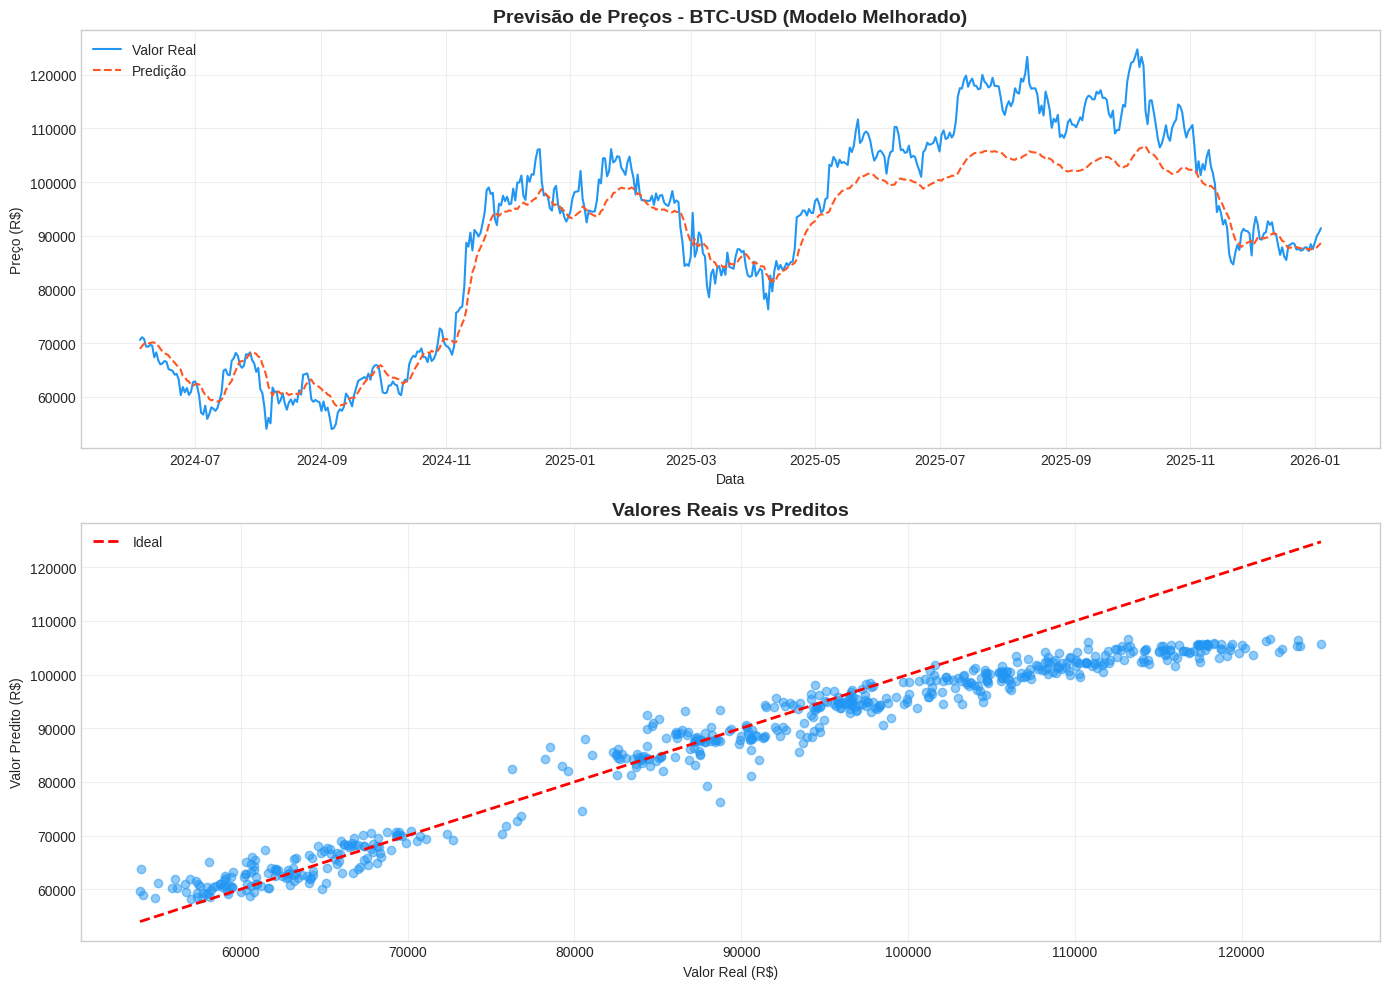

In [20]:
# Visualização: Valores Reais vs Preditos
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# As predições correspondem exatamente às datas de teste
# (full_test já inclui os dados de treino necessários para formar as sequências iniciais)
plot_dates = test_dates

axes[0].plot(plot_dates, y_true, label='Valor Real', color='#2196F3', linewidth=1.5)
axes[0].plot(plot_dates, y_pred, label='Predição', color='#FF5722', linewidth=1.5, linestyle='--')
axes[0].set_title(f'Previsão de Preços - {SYMBOL} (Modelo Melhorado)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Preço (R$)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_true, y_pred, alpha=0.5, color='#2196F3')
axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2, label='Ideal')
axes[1].set_title('Valores Reais vs Preditos', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Valor Real (R$)')
axes[1].set_ylabel('Valor Predito (R$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

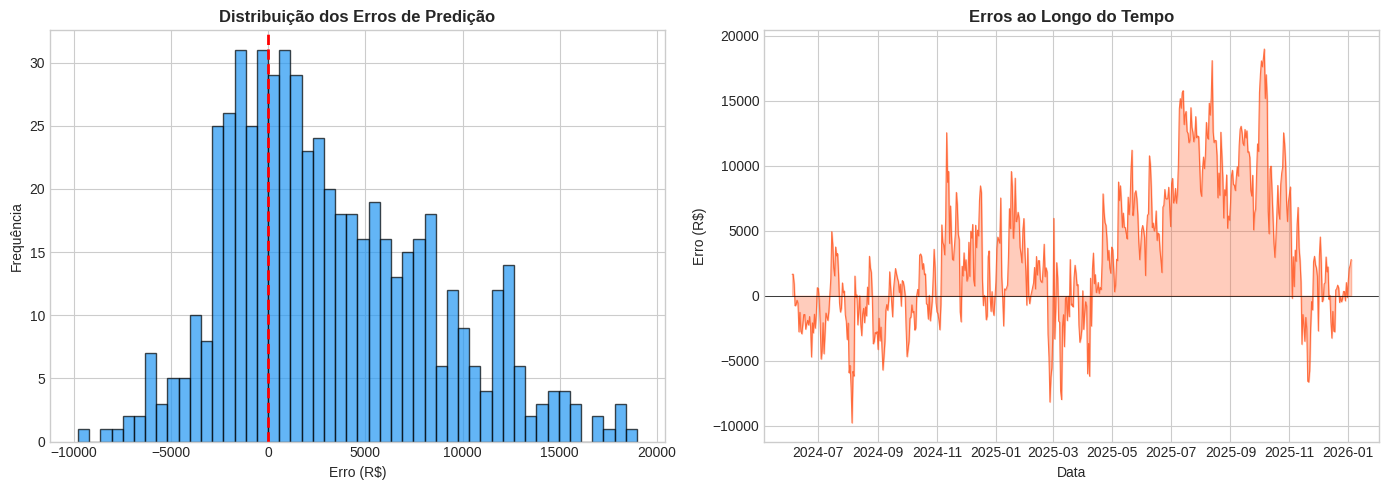


Estatísticas dos Erros:
  Média: R$ 3190.98
  Desvio Padrão: R$ 5249.06
  Mínimo: R$ -9771.39
  Máximo: R$ 18968.05


In [21]:
# Análise dos erros
errors = y_true - y_pred
plot_dates = test_dates

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição dos erros
axes[0].hist(errors, bins=50, color='#2196F3', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Distribuição dos Erros de Predição', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Erro (R$)')
axes[0].set_ylabel('Frequência')

# Erros ao longo do tempo
axes[1].plot(plot_dates, errors, color='#FF5722', linewidth=0.8, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].fill_between(plot_dates, errors, alpha=0.3, color='#FF5722')
axes[1].set_title('Erros ao Longo do Tempo', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Erro (R$)')

plt.tight_layout()
plt.savefig('./data/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nEstatísticas dos Erros:")
print(f"  Média: R$ {errors.mean():.2f}")
print(f"  Desvio Padrão: R$ {errors.std():.2f}")
print(f"  Mínimo: R$ {errors.min():.2f}")
print(f"  Máximo: R$ {errors.max():.2f}")

## 8. Salvamento do Modelo

Exportamos o modelo treinado e o scaler para uso na API.

In [22]:
# Cria diretório de modelos se não existir
os.makedirs('../models', exist_ok=True)

# Salva o modelo
MODEL_PATH = '../models/lstm_model.keras'
model.save(MODEL_PATH)
print(f"✓ Modelo salvo em: {MODEL_PATH}")

# Salva os scalers
SCALER_FEATURES_PATH = '../models/scaler_features.pkl'
SCALER_TARGET_PATH = '../models/scaler.pkl'  # Mantém compatibilidade com API

joblib.dump(scaler_features, SCALER_FEATURES_PATH)
joblib.dump(scaler_target, SCALER_TARGET_PATH)
print(f"✓ Scaler de features salvo em: {SCALER_FEATURES_PATH}")
print(f"✓ Scaler de target salvo em: {SCALER_TARGET_PATH}")

# Salva lista de features usadas
FEATURES_PATH = '../models/feature_columns.json'
with open(FEATURES_PATH, 'w') as f:
    json.dump(FEATURE_COLUMNS, f)
print(f"✓ Lista de features salva em: {FEATURES_PATH}")

✓ Modelo salvo em: ../models/lstm_model.keras
✓ Scaler de features salvo em: ../models/scaler_features.pkl
✓ Scaler de target salvo em: ../models/scaler.pkl
✓ Lista de features salva em: ../models/feature_columns.json


In [23]:
# Salva resultados do treinamento
training_results = {
    "symbol": SYMBOL,
    "training_start": START_DATE,
    "training_end": datetime.now().isoformat(),
    "model_version": "2.0_improved",
    "parameters": {
        "sequence_length": SEQUENCE_LENGTH,
        "train_ratio": TRAIN_RATIO,
        "epochs_configured": EPOCHS,
        "epochs_run": len(history.history['loss']),
        "batch_size": BATCH_SIZE,
        "architecture": "Bidirectional LSTM + BatchNorm + L2 Reg",
        "lstm_units": [128, 64, 32],
        "dropout_rate": 0.3,
        "learning_rate": 0.001,
        "loss_function": "huber",
        "l2_regularization": 0.001,
        "gradient_clipping": 1.0
    },
    "features": {
        "columns": FEATURE_COLUMNS,
        "n_features": len(FEATURE_COLUMNS)
    },
    "data_info": {
        "total_records": len(df_clean),
        "train_records": len(train_data),
        "test_records": len(test_data),
        "price_min": float(df_clean['Close'].min()),
        "price_max": float(df_clean['Close'].max()),
        "price_mean": float(df_clean['Close'].mean())
    },
    "training_history": {
        "final_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history['val_loss'][-1]),
        "best_val_loss": float(min(history.history['val_loss']))
    },
    "evaluation_metrics": metrics,
    "saved_files": {
        "model": MODEL_PATH,
        "scaler_features": SCALER_FEATURES_PATH,
        "scaler_target": SCALER_TARGET_PATH,
        "feature_columns": FEATURES_PATH
    }
}

# Salva JSON
RESULTS_PATH = '../models/training_results.json'
with open(RESULTS_PATH, 'w', encoding='utf-8') as f:
    json.dump(training_results, f, indent=2, ensure_ascii=False)

print(f"✓ Resultados salvos em: {RESULTS_PATH}")

✓ Resultados salvos em: ../models/training_results.json


## 9. Resumo Final

### Resultados do Treinamento

In [24]:
print("\n" + "=" * 70)
print("              RESUMO DO TREINAMENTO (MODELO MELHORADO)")
print("=" * 70)
print(f"\n  📊 Ação: {SYMBOL}")
print(f"  📅 Período: {START_DATE} até {END_DATE}")
print(f"  📈 Total de registros: {len(df_clean)}")
print(f"\n  🔧 Configurações:")
print(f"     - Sequence Length: {SEQUENCE_LENGTH} dias")
print(f"     - Train/Test Split: {int(TRAIN_RATIO*100)}/{int((1-TRAIN_RATIO)*100)}")
print(f"     - Épocas executadas: {len(history.history['loss'])}")
print(f"     - Features utilizadas: {len(FEATURE_COLUMNS)}")
print(f"\n  🏗️ Arquitetura:")
print(f"     - Bidirectional LSTM + BatchNormalization")
print(f"     - L2 Regularization (0.001)")
print(f"     - Dropout: 0.3")
print(f"     - Loss: Huber (robusta a outliers)")
print(f"\n  📉 Métricas de Avaliação:")
print(f"     - MAE:  R$ {mae:.2f}")
print(f"     - RMSE: R$ {rmse:.2f}")
print(f"     - MAPE: {mape:.2f}%")
print(f"     - R²:   {r2:.4f}")
print(f"\n  💾 Arquivos salvos:")
print(f"     - {MODEL_PATH}")
print(f"     - {SCALER_FEATURES_PATH}")
print(f"     - {SCALER_TARGET_PATH}")
print(f"     - {RESULTS_PATH}")
print("\n" + "=" * 70)
print("           ✅ TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("=" * 70)


              RESUMO DO TREINAMENTO (MODELO MELHORADO)

  📊 Ação: BTC-USD
  📅 Período: 2018-01-01 até 2026-01-05
  📈 Total de registros: 2897

  🔧 Configurações:
     - Sequence Length: 60 dias
     - Train/Test Split: 80/19
     - Épocas executadas: 127
     - Features utilizadas: 12

  🏗️ Arquitetura:
     - Bidirectional LSTM + BatchNormalization
     - L2 Regularization (0.001)
     - Dropout: 0.3
     - Loss: Huber (robusta a outliers)

  📉 Métricas de Avaliação:
     - MAE:  R$ 4595.28
     - RMSE: R$ 6142.88
     - MAPE: 4.69%
     - R²:   0.9002

  💾 Arquivos salvos:
     - ../models/lstm_model.keras
     - ../models/scaler_features.pkl
     - ../models/scaler.pkl
     - ../models/training_results.json

           ✅ TREINAMENTO CONCLUÍDO COM SUCESSO!


---

## 📝 Notas para Demonstração em Vídeo

### Tópicos a abordar:

1. **Introdução**
   - Apresentação do problema: previsão de preços de ações
   - Por que LSTM? Memória de longo prazo para séries temporais

2. **Coleta de Dados**
   - Uso do Yahoo Finance via yfinance
   - Empresa escolhida: Petrobras (PETR4.SA)

3. **Pré-processamento**
   - Importância da normalização para redes neurais
   - Split cronológico (não aleatório!) para séries temporais
   - Criação de sequências de 60 dias

4. **Arquitetura do Modelo**
   - 3 camadas LSTM com Dropout
   - Explicar return_sequences
   - Total de parâmetros treináveis

5. **Treinamento**
   - Callbacks: EarlyStopping e ReduceLROnPlateau
   - Evolução do loss

6. **Avaliação**
   - Métricas: MAE, RMSE, MAPE, R²
   - Interpretação dos resultados
   - Gráfico de predições vs reais

7. **API em Funcionamento**
   - Demonstrar endpoints /predict e /health
   - Mostrar Swagger UI (/docs)
   - Fazer predição em tempo real

8. **Monitoramento**
   - Dashboard Grafana
   - Métricas Prometheus

---